Pull in the data for the water flow 

In [2]:
import pandas as pd
import csv
import requests
import os

In [3]:
# change to the path with the raw csv file
path=r'C:\Springboard\Github\River_Analysis'
os.chdir(path)

Instead of pulling this data from a CSV, we need to pull it directly from the USGS page (and maybe save it to a CSV)

In [4]:
### link to USGS data for each gage

# may need to pull the start and end dates first

# then pull the daily data using that start and end dates

# See 06_data_extraction from gauge_info


# pull in the CSV data that we already have for Eagle River at Avon
raw_file = '09067020.csv'

# read the raw CSV back in and remove the commented lines
# open raw CSV
fi = open(raw_file, 'r')

# read raw CSV to clean CSV - eliminate comment rows with "#"
clean_file = 'clean.csv'
with open(clean_file, 'w') as fo:
    lines = fi.readlines()
    for line in lines:
        if "#" not in line:
            fo.write(line)
fi.close()

In [5]:
# load daily water flow into a DF
flow = pd.read_csv(clean_file, error_bad_lines=False, delimiter='\t')
flow

,agency_cd,site_no,datetime,18611_00060_00003,18611_00060_00003_cd
0,5s,15s,20d,14n,10s
1,USGS,09067020,1999-10-01,152,A
2,USGS,09067020,1999-10-02,142,A
3,USGS,09067020,1999-10-03,134,A
4,USGS,09067020,1999-10-04,126,A
...,...,...,...,...,...
7908,USGS,09067020,2021-05-25,885,P
7909,USGS,09067020,2021-05-26,927,P
7910,USGS,09067020,2021-05-27,855,P
7911,USGS,09067020,2021-05-28,950,P


That looks pretty good. I would like to include more of the summer, but that can happen later. Let's drop some of the useless columns and rows.

In [6]:
# drop the first row - that looks like useless data
flow.drop(0, inplace=True)
flow

,agency_cd,site_no,datetime,18611_00060_00003,18611_00060_00003_cd
1,USGS,09067020,1999-10-01,152,A
2,USGS,09067020,1999-10-02,142,A
3,USGS,09067020,1999-10-03,134,A
4,USGS,09067020,1999-10-04,126,A
5,USGS,09067020,1999-10-05,124,A
...,...,...,...,...,...
7908,USGS,09067020,2021-05-25,885,P
7909,USGS,09067020,2021-05-26,927,P
7910,USGS,09067020,2021-05-27,855,P
7911,USGS,09067020,2021-05-28,950,P


In [7]:
# rename columns to make for easier dropping
flow.columns = ['agency', 'gage', 'date', 'y', 'useless']
flow

,agency,gage,date,y,useless
1,USGS,09067020,1999-10-01,152,A
2,USGS,09067020,1999-10-02,142,A
3,USGS,09067020,1999-10-03,134,A
4,USGS,09067020,1999-10-04,126,A
5,USGS,09067020,1999-10-05,124,A
...,...,...,...,...,...
7908,USGS,09067020,2021-05-25,885,P
7909,USGS,09067020,2021-05-26,927,P
7910,USGS,09067020,2021-05-27,855,P
7911,USGS,09067020,2021-05-28,950,P


In [8]:
flow.drop(['agency', 'gage', 'useless'], axis=1, inplace=True)
flow

,date,y
1,1999-10-01,152
2,1999-10-02,142
3,1999-10-03,134
4,1999-10-04,126
5,1999-10-05,124
...,...,...
7908,2021-05-25,885
7909,2021-05-26,927
7910,2021-05-27,855
7911,2021-05-28,950


In [9]:
flow['y'] = flow['y'].astype(float)

In [10]:
# let's check for NaN values
flow['y'].isna().value_counts()

False    7912
Name: y, dtype: int64

that looks all filled to me. Time to rename the date column and run FB prophet

In [11]:
flow.rename(columns={'date':'ds'}, inplace=True)

INFO:numexpr.utils:NumExpr defaulting to 4 threads.


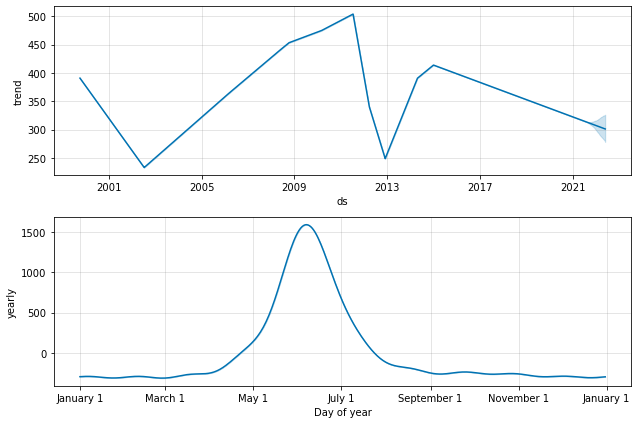

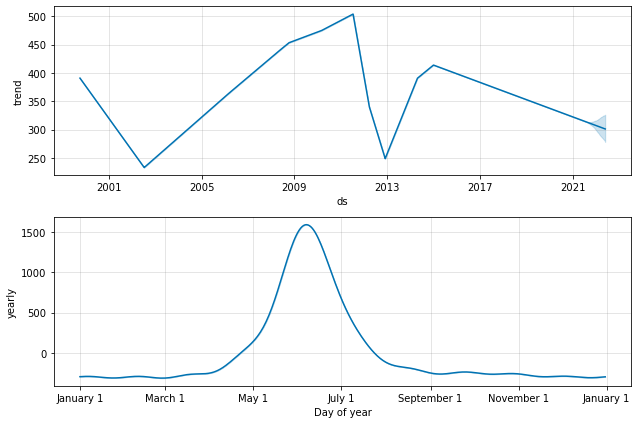

In [12]:
# let's take a better look at this with FB's Prophet - not considering any other regressors yet
from fbprophet import Prophet
m_fb = Prophet(yearly_seasonality = True, daily_seasonality=False, weekly_seasonality=False)
m_fb.fit(flow)
future = m_fb.make_future_dataframe(periods=365)
forecast = m_fb.predict(future)
m_fb.plot_components(forecast)

Next steps: how do I get the min / max / median / mean from each independent calendar day? <br>
<br>
Perhaps group by month and day

In [13]:
# add day and month columns to the existing DF
flow["Month"] = flow['ds'].str[5:7]
flow["Day"] = flow['ds'].str[8:10]
flow['MD'] = flow["Month"] + '-' + flow["Day"]

In [14]:
flow.dtypes

ds        object
y        float64
Month     object
Day       object
MD        object
dtype: object

In [15]:
flow['Month'] = flow['Month'].astype(int)
flow['Day'] = flow['Day'].astype(int)

In [16]:
summary = flow.groupby(["MD"], as_index=False)['y'].agg(['mean', 'min', 'median', 'max'])
summary

,mean,min,median,max
MD,,,,
01-01,65.277273,38.1,64.85,87.0
01-02,63.290909,36.6,64.80,84.0
01-03,64.009091,30.7,65.50,83.2
01-04,65.231818,33.8,64.40,92.7
01-05,63.209091,34.8,62.55,88.1
...,...,...,...,...
12-27,64.072727,40.6,62.95,91.4
12-28,62.777273,37.0,61.80,88.7
12-29,64.663636,31.8,63.85,84.8


In [17]:
# let's check these values
summary.describe()

,mean,min,median,max
count,366.000000,366.000000,366.000000,366.000000
mean,363.873733,119.244262,324.019536,840.940710
std,515.896185,157.531733,473.879924,1212.244706
min,61.340909,23.200000,59.850000,71.200000
25%,67.278409,41.200000,66.462500,102.000000
50%,114.048485,52.900000,102.950000,226.000000
75%,354.635714,85.350000,282.500000,907.250000
max,2150.238095,738.000000,2170.000000,4390.000000


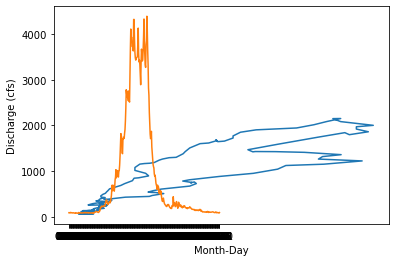

In [18]:
# summary['median'], 
import matplotlib.pyplot as plt
_ = plt.plot(summary['min'], summary['mean'], summary['max'])
_ = plt.xlabel('Month-Day')
_ = plt.ylabel('Discharge (cfs)')

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


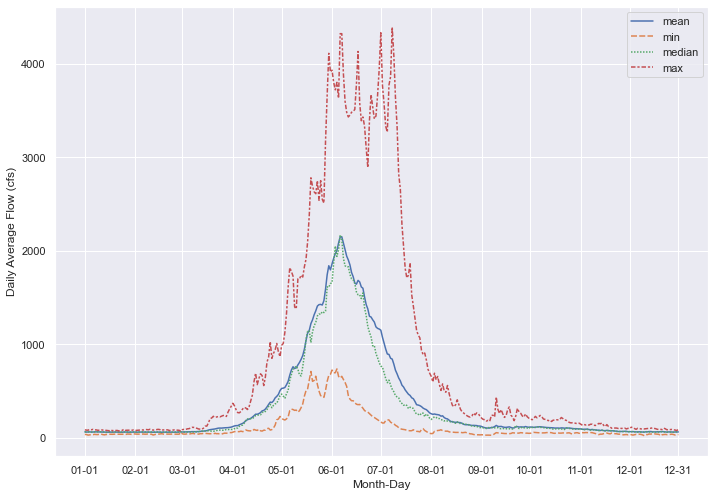

In [22]:
import seaborn as sns
# set the figure size
sns.set(rc={'figure.figsize':(11.7,8.27)})
# create the plot
g  = sns.lineplot(data=summary) # , x='MD', y=['min', 'mean', 'max', 'median'])
_ = plt.xticks(['01-01', '02-01', '03-01', '04-01', '05-01', '06-01', '07-01', '08-01', '09-01', '10-01', '11-01', '12-01', '12-31'])
plt.xlabel('Month-Day')
plt.ylabel('Daily Average Flow (cfs)')
plt.savefig('Eagle_River.png',bbox_inches='tight')
# g.set_xticks(25)

# g.set_xticklabels(['0','a','b','c','d','e'])
# need to resize
# need to space the markers out more
# need to save this plot so we can add it to a HTML site